In [8]:
# all the required python packages
import sys

# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install numpy
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install deepface
# !{sys.executable} -m pip install pillow
# !{sys.executable} -m pip install cv2
# !{sys.executable} -m pip install mediapipe
# !{sys.executable} -m pip install roboflow
# !{sys.executable} -m pip install nltk
# !{sys.executable} -m pip install sklearn
# !{sys.executable} -m pip install joblib

# 1. Problem Statement


# Prepare Dataset

### Download WIDERFACE Validation dataset

### Randomly choose around 300 images for validation

### Upload the images to roboflow and annotate the faces with facial expressions 

# Download Dataset

url: https://app.roboflow.com/nitesh-c-eszzc/fed_wider_face_mini/2

In [18]:
import roboflow

from robowrapper import RoboProj
from dataset import COCODatasetBuilder
from imagewrapper import ImageIterator


ROBOFLOW_ROOT_DIR = './.data/robo'
SAMPLE_IMG_NAME = 'fer_wider_face_sample_jpg'
sample_img_path = None

roboflow.login()
rf = roboflow.Roboflow()

proj_wfacemini =  RoboProj(
    rf, 
    rf_proj=rf.project('nitesh-c-eszzc/fed_wider_face_mini'),
    proj_ver=2
)
ds_wfacemini = proj_wfacemini.download(
    dataset_path=ROBOFLOW_ROOT_DIR+'/fed_wider_face_mini',
    dataset_format='coco')
wfacemini_val_dir = ds_wfacemini.get_all_images_dir()[0]
coco_ds = COCODatasetBuilder.build_from_file(ds_wfacemini.get_all_labels_dir()[0])

img_itr = ImageIterator(wfacemini_val_dir)
for img_path in img_itr:
    if SAMPLE_IMG_NAME in img_path:
       sample_img_path = img_path
       break 

You are already logged into Roboflow. To make a different login,run roboflow.login(force=True).



Extracting Dataset Version Zip to ./.data/robo/fed_wider_face_mini in coco:: 100%|██████████| 311/311 [00:00<00:00, 746.08it/s]


randomly check an image from dataset with ground truth labels

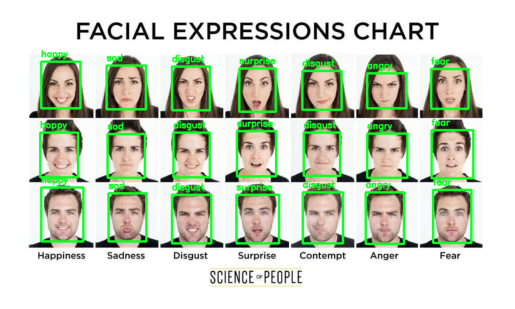

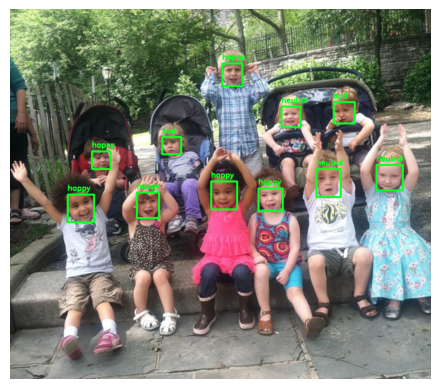

In [17]:
import random
import numpy

from imagewrapper import ImageIterator
from imagewrapper import CVImageWrapper
from matplotlib import pyplot as plt

from pathlib import Path

img = CVImageWrapper(sample_img_path)
anns = coco_ds.get_bbox(Path(sample_img_path).name)
labels = [a[0] for a in anns]
bboxes = numpy.array([a[1] for a in anns])
img.annotate(bboxes, labels)
img.imshow(plt)


img_itr = ImageIterator(wfacemini_val_dir)
rand_img_path = img_itr[random.randint(0, len(img_itr)-1)]

img = CVImageWrapper(rand_img_path)
anns = coco_ds.get_bbox(Path(rand_img_path).name)
labels = [a[0] for a in anns]
bboxes = numpy.array([a[1] for a in anns])
img.annotate(bboxes, labels)
img.imshow(plt)



# Define the evaluator

In [32]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

class GroupFEREvaluator:
    def sentencify(labels):
        return ' '.join(sorted(labels))
        
    def evaluate_one(actual_labels, predict_labels):
        ref = GroupFEREvaluator.sentencify(actual_labels)
        cand = GroupFEREvaluator.sentencify(predict_labels)
        return round(sentence_bleu([ref], cand, weights=[1]), 2)
    
    def evaluate_all(tuples):
        refs = [ [GroupFEREvaluator.sentencify(r)] for r,_ in tuples]
        cands = [ GroupFEREvaluator.sentencify(c) for _,c in tuples]
        return round(corpus_bleu(refs, cands, weights=[1]), 2)

print(GroupFEREvaluator.evaluate_one(['angry'], ['sad']))
print(GroupFEREvaluator.evaluate_all([(['angry'], ['sad'])]))

0.17
0.17


# Get the Model

In [33]:
from deepface import DeepFace
import numpy as np

class DeepFaceWrapper:
  def __init__(
    self,
    backend='retinaface', 
    emotion_threshold=0.5,
    default_emotion='neutral'
  ) -> None:
    self.img_path = img_path
    self.backend = backend
    self.emotion_threshold = emotion_threshold
    self.default_emotion = default_emotion
  
  def _to_bboxes(self, face_objs):
    return np.array([
      np.array([
          face['region']['x'], 
          face['region']['y'], 
          face['region']['w'], 
          face['region']['h']
      ]) for face in face_objs
    ])
  
  def _to_labels(self, face_objs):
    def _to_emotion(face):
      dominant_emotion = face['dominant_emotion']
      if face['emotion'][dominant_emotion] > self.emotion_threshold:
        return dominant_emotion
      else:
        return self.default_emotion
    return [ _to_emotion(face) for face in face_objs]
  
  def predict(self, img_path):
    face_objs = DeepFace.analyze(
        img_path = img_path,
        detector_backend = self.backend,
        enforce_detection=False,
        actions = ['emotion'], align=True, silent=True
      )
    return (self._to_labels(face_objs), self._to_bboxes(face_objs))

# below backend are availabel from the deepface library
backends = [
  'opencv', 
  'ssd', 
  'dlib', 
  'mtcnn', 
  'retinaface', 
  'mediapipe'
]

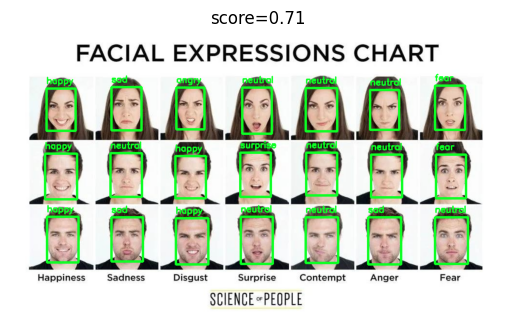

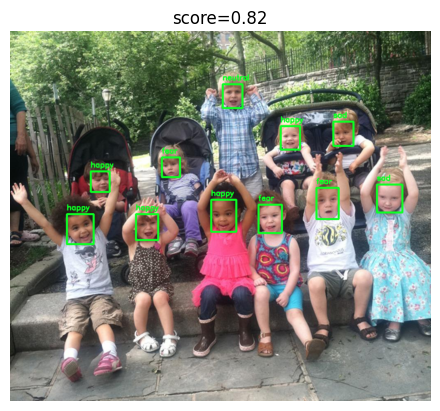

In [39]:
from imagewrapper import CVImageWrapper
from matplotlib import pyplot as plt
from pathlib import Path

# predict & evaluate for sample image
labels, bboxes = DeepFaceWrapper().predict(sample_img_path)
img = CVImageWrapper(sample_img_path)
img.annotate(bboxes, labels)
actual_labels = [a[0] for a in coco_ds.get_bbox(Path(sample_img_path).name)]
score = GroupFEREvaluator.evaluate_one(actual_labels, labels)
plt.title('score='+str(score))
img.imshow(plt)

# predict & evaluate for random image
labels, bboxes = DeepFaceWrapper().predict(rand_img_path)
img = CVImageWrapper(rand_img_path)
img.annotate(bboxes, labels)
actual_labels = [a[0] for a in coco_ds.get_bbox(Path(rand_img_path).name)]
score = GroupFEREvaluator.evaluate_one(actual_labels, labels)
plt.title('score='+str(score))
img.imshow(plt)

# Predict & Evaluate on complete dataset

In [81]:
class ModelTester:
    def __init__(self, backend='retinaface', emotion_threshold=0.5) -> None:
        self.name  = '{}-{}-{}'.format('deepface', backend, emotion_threshold)
        self.model_obj = DeepFaceWrapper(backend=backend, emotion_threshold=emotion_threshold)
        self.model = lambda x: self.model_obj.predict(x)
        self.evaluator = lambda x: GroupFEREvaluator.evaluate_all(x)
        self.truth_getter = lambda x: [a[0] for a in coco_ds.get_bbox(Path(x).name)]
    
    def test(self, itr: ImageIterator) -> float:
        tuples = []
        results = {}
        
        for img_path in itr:
            labels, bboxes = self.model(img_path)
            actual_labels = self.truth_getter(img_path)
            tuples.append((actual_labels, labels))
            
            results[img_path] = {
                'labels': labels,
                'bboxes': bboxes,
                'actual_labels': actual_labels,
                'score': self.evaluator([(actual_labels, labels)])
            }
        score = self.evaluator(tuples)
        return score, results

In [82]:
from sklearn.model_selection import ParameterGrid

params = ParameterGrid({
    'bcknd': backends,
    'th': [0.25, 0.5, 0.75]
})

models = {}
for param in params:
    model = ModelTester(backend=param['bcknd'], emotion_threshold=param['th'])
    models[model.name] = model

In [83]:
from joblib import Parallel, delayed

def run_models(models, data, jobs=4):
    parallel = Parallel(n_jobs=jobs, return_as="generator")
    
    def wrap_call(key, model, data):
        score, results = model(data)
        return key, score, results
    
    keys = models.keys()
    output_generator = parallel(delayed(wrap_call)(key, models[key], data) for key in keys)
    
    runs = {}
    for output in output_generator:
        runs[output[0]] = (output[1], output[2])

In [ ]:
# models = {'test': ModelTester(backend='opencv')}
data = ImageIterator(wfacemini_val_dir)
runs = run_models(models, data, jobs=4)

In [85]:
import pandas as pd

best_model = ('', 0, {})
scores_df = pd.DataFrame(columns=['model', 'score'])
for key in runs.keys():
    scores_df.loc[len(scores_df)] = [key, runs[key][0]]
    if best_model[1] < runs[key][0]:
        best_model = (key, runs[key][0], runs[key][1])

print('best model is', best_model[0], 'with score of', best_model[1])
scores_df.sort_values(by = 'score')
scores_df

Lets pick 4 images from lower scores, mid scores and high scores and compare the predictions with ground truth ones

In [50]:
results = best_model[2]
scores = [(k, results[k]['score']) for k in results.keys()]
scores.sort(key=lambda a: a[1])
scores = np.array(scores)
print(
    "n_scores =", len(scores), 
    "low_score =", scores[0][1], 
    "mid_score =", scores[len(scores)//2][1], 
    "high_score =", scores[len(scores)-1][1]
)

low_scores = scores[0:4]
mid_scores = scores[len(scores)//2-2:len(scores)//2+2]
high_scores = scores[-4:]
print(
    "low scores =", [s[1] for s in low_scores], 
    "\nmid scores =", [s[1] for s in mid_scores], 
    "\nhigh scores =", [s[1] for s in high_scores])

n_scores = 307 low_score = 0.0 mid_score = 0.27 high_score = 1.0
low scores = ['0.0', '0.0', '0.0', '0.0'] 
mid scores = ['0.26', '0.27', '0.27', '0.27'] 
high scores = ['1.0', '1.0', '1.0', '1.0']


In [74]:
from pathlib import Path
from typing import Any
from imagewrapper import CVImageWrapper

import numpy as np
from matplotlib import pyplot as plt

def get_img_paths(scores):
    return [s[0] for s in scores]

class GroundTruthImage:
    def __init__(self, ds=coco_ds) -> None:
        self.ds = coco_ds
    
    def __call__(self, *args: Any, **kwds: Any) -> Any:
        image_name = Path(args[0]).name
        tuples = coco_ds.get_bbox(image_name)
        bboxes = np.array([t[1] for t in tuples])
        labels = [t[0] for t in tuples]
        img = CVImageWrapper(args[0])
        img.annotate(bboxes, labels)
        return img

class  ImageOrganizer:
    def __init__(self, test_results=results, truth_dataset=coco_ds) -> None:
        self.test_results = test_results
        self.truth_dataset = GroundTruthImage(truth_dataset)
        self.ds = truth_dataset
    
    def fill_axis(self, ax, img: CVImageWrapper, score, label_counts):
        ax.imshow(img.printformat(), cmap = plt.cm.Spectral)
        ax.set_axis_off()
        ax.set_title('score = {}'.format(score))
        labels_str = ', '.join(['{}={}'.format(k,v) for (k,v) in label_counts])
        ax.text(0, 0, labels_str, fontsize=8)
        
    def organize(self, group_truths, predicts) -> None:
        for i, _ in enumerate(group_truths):
            fig, (tax1, pax1)  = plt.subplots(1, 2)
                
            (img, score, label_counts)  = group_truths[i]
            self.fill_axis(tax1, img, score, label_counts)
            
            (img, score, label_counts)  = predicts[i]
            self.fill_axis(pax1, img, score, label_counts)
            
        plt.show(block=True)
    
    def to_label_counts(self, labels):
        label_counts = {}
        for l in labels:
            if l in label_counts.keys():
                label_counts[l] += 1
            else:
                label_counts[l] = 1
        
        label_counts = [(k, label_counts[k]) for k in label_counts.keys()]
        return sorted(label_counts, key=lambda r: r[0])
        
    def collect_and_organize(self, scores):
        truth_tuples = []
        prdict_tuples = []
        
        img_paths = [s[0] for s in scores]
        for img_path in img_paths:
            truth_image = self.truth_dataset(img_path)
            image_name = Path(img_path).name
            tuples = self.ds.get_bbox(image_name)
            truth_tuples.append((
                truth_image, 
                1.0, 
                self.to_label_counts([t[0] for t in tuples])))
            
            pred_image = CVImageWrapper(img_path)
            pred_image.annotate(
                results[img_path]['bboxes'], 
                results[img_path]['labels'])
            prdict_tuples.append((
                pred_image, 
                results[img_path]['score'], 
                self.to_label_counts(results[img_path]['labels'])))
        
        self.organize(truth_tuples, prdict_tuples)

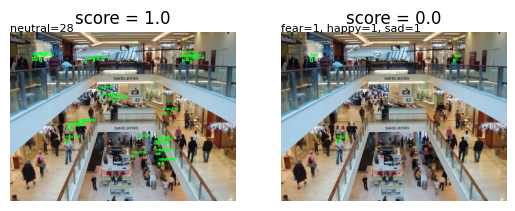

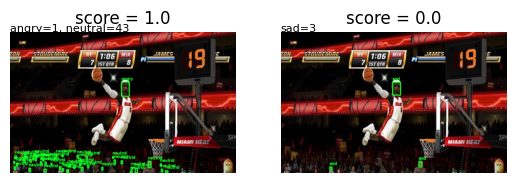

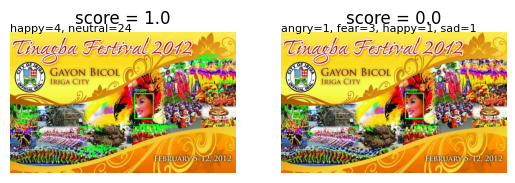

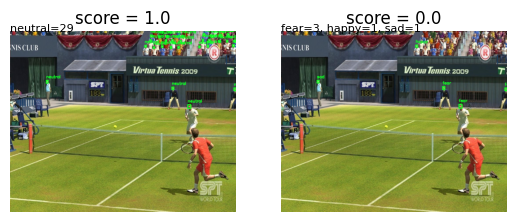

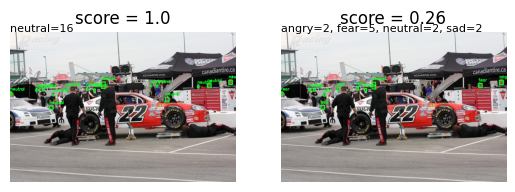

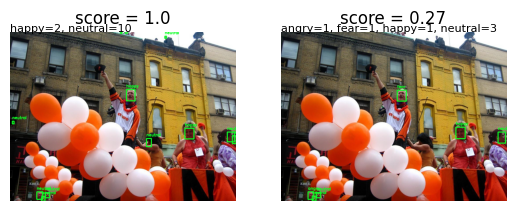

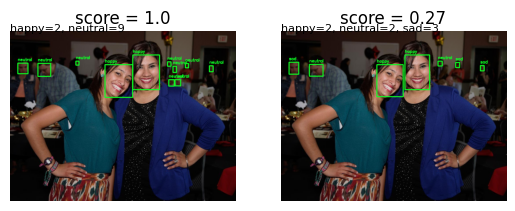

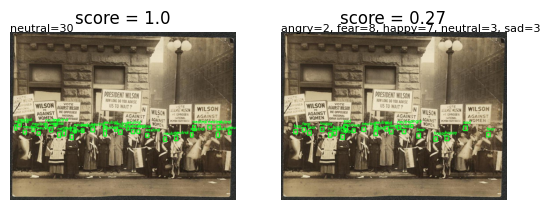

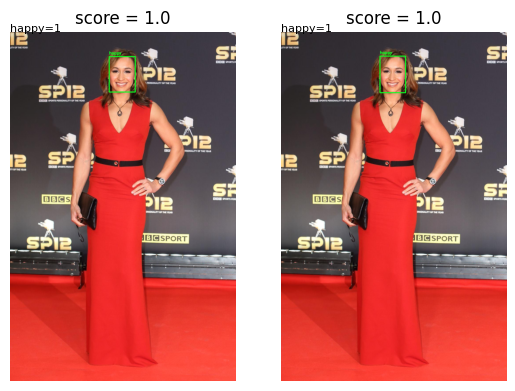

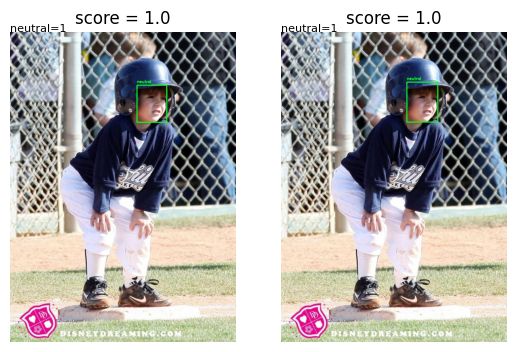

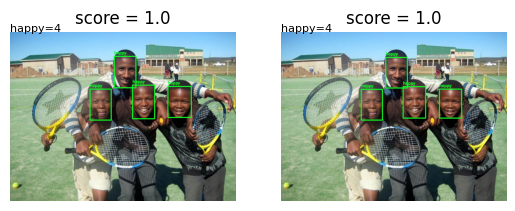

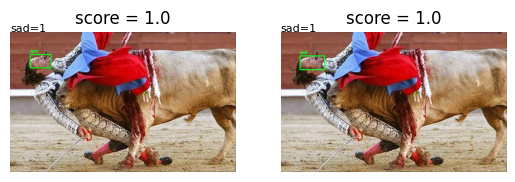

In [75]:
organizer = ImageOrganizer(results, coco_ds)

organizer.collect_and_organize(low_scores)
organizer.collect_and_organize(mid_scores)
organizer.collect_and_organize(high_scores)